In [1]:
import numpy as np
import pandas as pd
import os
import re

In [2]:
import collections
import html

from fastai.text import *

In [3]:
re1 = re.compile(r'  +')

def fixup(x):
    '''some patterns identified by the fast.ai folks that spacy doesn't account for'''
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, n_lbls):
    '''tokenize the text'''
    tok, labels = [], []
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [4]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

# path to our original tweet data from kaggle
PATH = './data'

In [5]:
# path to our classification data
CLASSIFICATION_PATH = './classification'

# path to our language model
LANGUAGE_MODEL_PATH = './language_model'

In [6]:
CLASSES = ['neg', 'pos']

In [7]:
# df = pd.read_csv(PATH + '/train.csv', encoding='latin1')
# df = df.drop('ItemID', axis=1)

# split_index       = int(df.shape[0] * 0.9)
# train_df, test_df = np.split(df, [split_index], axis=0)
# # save to classification directory
# train_df.to_csv(CLASSIFICATION_PATH + '/train.csv', header=False, index=False, encoding='utf-8')
# test_df.to_csv(CLASSIFICATION_PATH + '/test.csv', header=False, index=False, encoding='utf-8')

# f = open(CLASSIFICATION_PATH + '/classes.txt', 'w', encoding='utf-8')
# f.writelines(f'{c}\n' for c in CLASSES)
# f.close()

# # save to language model directory
# # we should be adding in the test.csv from the kaggle competition here because the language model doesn't care about labels
# # but in the interest of time I'm opting to just use the training set for the language model
# train_df.to_csv(LANGUAGE_MODEL_PATH + '/train.csv', header=False, index=False, encoding='utf-8')
# test_df.to_csv(LANGUAGE_MODEL_PATH + '/test.csv', header=False, index=False, encoding='utf-8')

## Data Read and Tokenization

In [8]:
chunksize = 24000
train_df  = pd.read_csv(LANGUAGE_MODEL_PATH + '/train.csv', header=None, chunksize=chunksize)
val_df    = pd.read_csv(LANGUAGE_MODEL_PATH + '/test.csv',  header=None, chunksize=chunksize)

In [9]:
train_tokens, train_labels = get_all(train_df, 1)
val_tokens, val_labels = get_all(val_df, 1)

In [10]:
freq = Counter(token for tokens in train_tokens for token in tokens)

In [11]:
max_vocab = 60000
min_freq = 2

int_to_token = [o for o,c in freq.most_common(max_vocab) if c > min_freq]
int_to_token.insert(0, '_pad_')
int_to_token.insert(0, '_unk_')

In [25]:
token_to_int = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(int_to_token)})

In [26]:
train_lm = [[token_to_int[o] for o in sent] for sent in train_tokens]
val_lm   = [[token_to_int[o] for o in sent] for sent in val_tokens]

In [28]:
num_tokens = len(int_to_token)

## Pretrained Model

#### Setting up Pretrained Weights

In [29]:
#do not change this
embedding_size, num_hidden, num_layers = 400,1150,3

In [30]:
PRE_PATH = './data/models/wt103'
PRE_LM_PATH = PRE_PATH + '/fwd_wt103.h5'

In [31]:
weights = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [32]:
encoder_weights = to_np(weights['0.encoder.weight'])
encoder_mean = encoder_weights.mean(0)

In [33]:
wiki_int_to_token = pickle.load(open(PRE_PATH + '/itos_wt103.pkl', 'rb'))
wiki_token_to_int = collections.defaultdict(lambda: -1, {v:k for k,v in enumerate(wiki_int_to_token)})

In [34]:
new_weights = np.zeros((num_tokens, embedding_size), dtype=np.float32)
for i,w in enumerate(int_to_token):
    r = wiki_token_to_int[w]
    new_weights[i] = encoder_weights[r] if r >= 0 else encoder_mean

In [35]:
weights['0.encoder.weight'] = T(new_weights)
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_weights))
weights['1.decoder.weight'] = T(np.copy(new_weights))

In [36]:
new_weights.shape

(20080, 400)

#### Setting up Language Model

In [37]:
wd=1e-7   # weight decay
bptt=70   # ngram size.  i.e. the model sees ~70 tokens and then tries to predict the 71st
bs=52     # batch size
opt_fn = partial(optim.Adam, betas=(0.8, 0.99)) # optimazation function

In [38]:
train_dl = LanguageModelLoader(np.concatenate(train_lm), bs, bptt)
val_dl   = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)

In [39]:
md = LanguageModelData(PATH, 1, num_tokens, train_dl, val_dl, bs=bs, bptt=bptt)

In [40]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [41]:
learner = md.get_model(opt_fn, 
                       embedding_size, 
                       num_hidden, 
                       num_layers, 
                       dropouti=drops[0], 
                       dropout=drops[1],
                       wdrop=drops[2], 
                       dropoute=drops[3], 
                       dropouth=drops[4] 
  )
learner.metrics = [accuracy]

#### Fine tuning to our perticular dataset

In [42]:
learner.freeze_to(-1)
learner.model.load_state_dict(weights)

In [43]:
lr=1e-3
lrs = lr

In [44]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      5.006636   4.732727   0.261554  



[array([4.73273]), 0.2615536065506084]

In [45]:
learner.unfreeze()
learner.lr_find(start_lr = lr, end_lr=lr*50, linear=False)

epoch      trn_loss   val_loss   accuracy                   
    0      4.259381   4.164969   0.318485  



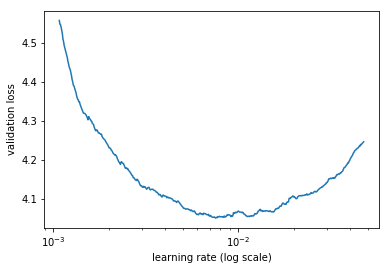

In [46]:
learner.sched.plot()

In [47]:
lr=(1e-2 + 1e-3)
learner.fit(lr/2, 1, wds=wd, use_clr=(32,2), cycle_len=2)

epoch      trn_loss   val_loss   accuracy                   
    0      3.95207    3.735109   0.360484  
    1      3.6234     3.589315   0.375033                   



[array([3.58931]), 0.3750325414751257]

In [48]:
learner.save('lm1')
learner.save_encoder('lm1_enc')

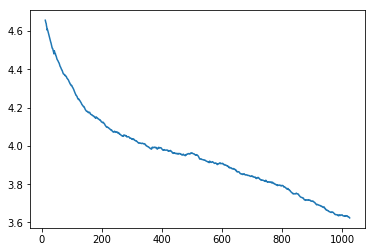

In [49]:
learner.sched.plot_loss()

## Classification

In [50]:
train_classification = np.squeeze(train_lm)
val_classification   = np.squeeze(val_lm)

train_labels = np.squeeze(np.array(train_labels))
val_labels = np.squeeze(np.array(val_labels))

In [51]:
# params
bptt, embedding_size, num_hidden, num_layers = 70, 400, 1150, 3
num_tokens = len(int_to_token)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

min_label = train_labels.min()
train_labels -= min_label
val_labels -= min_label
c = int(train_labels.max()) + 1

In [52]:
train_ds = TextDataset(train_classification, train_labels)
val_ds = TextDataset(val_classification, val_labels)
train_sampler = SortishSampler(train_classification, key=lambda x: len(train_classification[x]), bs=bs//2)
val_sampler = SortSampler(val_classification, key=lambda x: len(val_classification[x]))

train_dl = DataLoader(train_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=train_sampler)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_sampler)

md = ModelData(PATH, train_dl, val_dl)
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [53]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [54]:
m = get_rnn_classifier(bptt, 20*70, c, num_tokens, emb_sz=embedding_size, n_hid=num_hidden, n_layers=num_layers,
                       pad_token=1, layers=[embedding_size*3, 50, c], drops=[dps[4], 0.1], dropouti=dps[0],
                       wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [55]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [56]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr]) # differential learning rates

In [57]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [58]:
# freeze all except last layer
learn.freeze_to(-1)

 80%|████████  | 3009/3750 [00:56<00:13, 56.91it/s, loss=2.09] 

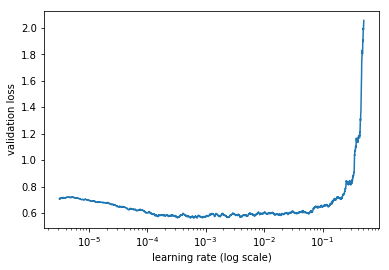

In [59]:
# to find learning rate
learn.lr_find(lrs/1000)
learn.sched.plot()

In [60]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.56992    0.493577   0.759876  


[array([0.49358]), 0.7598759874169475]

In [61]:
learn.freeze_to(-2)

In [62]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.540375   0.452379   0.788079  


[array([0.45238]), 0.7880788065544521]

In [63]:
learn.unfreeze()

In [64]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      0.47934    0.431734   0.79938   


[array([0.43173]), 0.7993799353321859]

In [65]:
learn.fit(lrs, 10, wds=wd, cycle_len=1, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      0.452428   0.420025   0.80428   
    1      0.457102   0.414973   0.808981                      
    2      0.445515   0.409637   0.812181                      
    3      0.417224   0.406997   0.816582                      
    4      0.439945   0.406102   0.814581                      
    5      0.421703   0.408337   0.815182                      
    6      0.410142   0.413029   0.814081                      
    7      0.394104   0.406337   0.818782                      
    8      0.417843   0.40913    0.818782                      
    9      0.39852    0.407645   0.820382                      


[array([0.40764]), 0.8203820386896468]

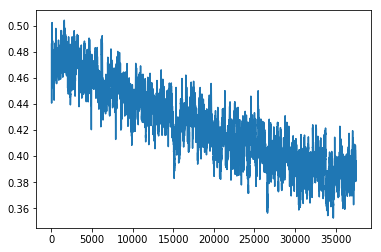

In [66]:
learn.sched.plot_loss()

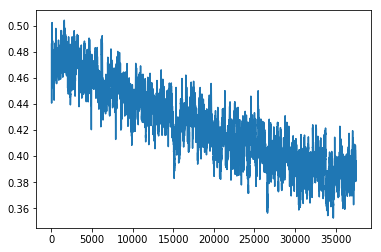

In [67]:
learn.sched.plot_loss()

In [68]:
learn.save('sentiment_classifier')